In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split

In [2]:
## Inputting data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test["PassengerId"]

train.drop(['PassengerId'],axis=1,inplace=True)
test.drop(['PassengerId'],axis=1,inplace=True)

all_data = pd.concat([train.drop('Survived',axis=1),test])
all_data['Title'] = all_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

all_data = all_data.replace({'male': 0, 'female': 1})
all_data.replace('Don','Mr',inplace=True)
all_data.replace(['Mme','Dona'],'Mrs',inplace=True)
all_data.replace(['Ms','Mlle'],'Miss',inplace=True)
all_data.replace(['Major','Col','Capt'],'Crew',inplace=True)
all_data.replace(['Lady','Sir','the Countess','Jonkheer'],'Nob',inplace=True)

all_data['Embarked'].fillna('S')


all_data_copy = all_data.copy()

In [7]:
## Converting categorical variables to numerical
all_data = pd.concat([all_data,pd.get_dummies(all_data['Embarked'])],axis=1)
all_data = pd.concat([all_data,pd.get_dummies(all_data['Title'])],axis=1)

all_data['Family'] = all_data['SibSp']+all_data['Parch']
all_data['Cabin'] = all_data['Cabin'].isna()
#all_data['Child'] = all_data['Age'].loc(all_data['Age']<16)
all_data['Age'].fillna(all_data.groupby(['Title','Pclass'])['Age'].transform("mean"),inplace=True)
all_data['Fare'].fillna(all_data.groupby(['Pclass','Embarked'])['Fare'].transform("mean"),inplace=True)
all_data['Child'] = all_data['Age']<16
all_data['MothChild'] = all_data['Sex']*all_data['Parch']
all_data['SingAdMale'] = all_data['Mr']*np.heaviside(-all_data_copy['Parch'],1)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
all_data = all_data[numeric_feats]
all_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,C,Q,S,...,Master,Miss,Mr,Mrs,Nob,Rev,Family,Child,MothChild,SingAdMale
0,3,0,22.0,1,0,7.2500,True,0,0,1,...,0,0,1,0,0,0,1,False,0,1.0
1,1,1,38.0,1,0,71.2833,False,1,0,0,...,0,0,0,1,0,0,1,False,0,0.0
2,3,1,26.0,0,0,7.9250,True,0,0,1,...,0,1,0,0,0,0,0,False,0,0.0
3,1,1,35.0,1,0,53.1000,False,0,0,1,...,0,0,0,1,0,0,1,False,0,0.0
4,3,0,35.0,0,0,8.0500,True,0,0,1,...,0,0,1,0,0,0,0,False,0,1.0


In [334]:
## Filling missing variables with the median (dumb replacement)
def medianreplace(data):
    k = (data.isna().sum()!=0).sum()
    idx = data.isna().sum().nlargest(k).index[::-1]
    for i in idx:
        data[i] = data[i].fillna(data[i].median())
    
    return data


In [335]:
## Smarter replace using groupby
def groupbymedianreplace(data,feat):
    k = (data.isna().sum()!=0).sum()
    idx = data.isna().sum().nlargest(k).index[::-1]
    for i in idx:
        data[i].fillna(data.groupby(feat)[i].transform("median"), inplace=True)
    
    return data


In [8]:
#all_data = medianreplace(all_data)
#all_data = groupbymedianreplace(all_data,['Sex','Pclass'])

#all_data['Age'] = np.log1p(all_data['Age'])
all_data['Age'] = (all_data['Age']-all_data['Age'].mean(axis=0))/all_data['Age'].std(axis=0)
all_data['Fare'] = np.log1p(all_data['Fare'])
all_data['Fare'] = (all_data['Fare']-all_data['Fare'].mean(axis=0))/all_data['Fare'].std(axis=0)
train = pd.concat([all_data.iloc[0:train.shape[0]],train['Survived']],axis=1)
test = all_data.iloc[train.shape[0]:]

In [9]:
corrmat = np.abs(train.corr())
k = train.shape[1]
cols = corrmat.nlargest(k, 'Survived')['Survived'].index
print(corrmat.nlargest(k, 'Survived')['Survived'],cols)

Survived      1.000000
Mr            0.551199
Sex           0.543351
SingAdMale    0.484548
Mrs           0.341994
Pclass        0.338481
Miss          0.335636
Fare          0.329862
Cabin         0.316912
C             0.168240
S             0.155660
MothChild     0.141291
Child         0.136884
Master        0.085221
Parch         0.081629
Age           0.072553
Rev           0.064988
Nob           0.050561
SibSp         0.035322
Family        0.016639
Dr            0.008185
Q             0.003650
Crew          0.002496
Name: Survived, dtype: float64 Index(['Survived', 'Mr', 'Sex', 'SingAdMale', 'Mrs', 'Pclass', 'Miss', 'Fare',
       'Cabin', 'C', 'S', 'MothChild', 'Child', 'Master', 'Parch', 'Age',
       'Rev', 'Nob', 'SibSp', 'Family', 'Dr', 'Q', 'Crew'],
      dtype='object')


In [17]:
for n in range(2,cols[1:].shape[0]):
    x = train[cols[1:n]].copy()
#    x.drop('Survived', axis=1,inplace = True)
    y = train['Survived']

    model = LogisticRegressionCV(cv = 5, fit_intercept= True,penalty='elasticnet',solver='saga')
    model.fit(x,y)
    print(model.score(x,y))
print(n)

0.7833894500561167
0.7867564534231201
0.7867564534231201
0.7867564534231201
0.7901234567901234
0.7901234567901234
0.7901234567901234
0.792368125701459
0.7934904601571269
0.792368125701459
0.813692480359147
0.8148148148148148
0.8294051627384961
0.8260381593714927
0.8294051627384961
0.8305274971941639
0.8282828282828283
0.8316498316498316
0.8316498316498316
0.8316498316498316
21


In [18]:
test_copy = test[cols[1:n]].copy()
predictions = model.predict(test_copy)
model.scores_

{1: array([[0.61452514, 0.62011173, 0.75418994, 0.84357542, 0.84357542,
         0.84357542, 0.84357542, 0.84357542, 0.84357542, 0.84357542],
        [0.61452514, 0.61452514, 0.7877095 , 0.80446927, 0.81564246,
         0.82122905, 0.82681564, 0.82681564, 0.82681564, 0.82681564],
        [0.61797753, 0.61797753, 0.78651685, 0.79213483, 0.79775281,
         0.80337079, 0.80337079, 0.80337079, 0.80337079, 0.80337079],
        [0.61797753, 0.61797753, 0.78651685, 0.8258427 , 0.8258427 ,
         0.79213483, 0.79213483, 0.79213483, 0.79213483, 0.79213483],
        [0.61581921, 0.61581921, 0.83615819, 0.84745763, 0.86440678,
         0.85310734, 0.84745763, 0.84745763, 0.84745763, 0.84745763]])}

In [15]:
submission = pd.DataFrame({"PassengerId":PassengerId, "Survived":predictions})
submission.to_csv("submission.csv", index=False)

In [84]:
score = np.zeros(cols[1:].shape[0])
for n in range(2,cols[1:].shape[0]+2):
    X_train, X_val, y_train, y_val = train_test_split(train[cols[n-1:n]].copy(), train['Survived'],
                                                      test_size=0.3, random_state=0)
#    print(X_train.shape,y_train.shape)
    model = LogisticRegressionCV(cv = 10, fit_intercept= True,penalty='elasticnet',solver='saga')
    model.fit(X_train,y_train)
    val_pred = model.predict(X_val)
    score[n-2] = (val_pred==y_val).sum()/y_val.shape[0]
    print((val_pred==y_val).sum()/y_val.shape[0])
cols[1:][np.argmax(score)]

0.7798507462686567
0.7873134328358209
0.746268656716418
0.6902985074626866
0.6940298507462687
0.7201492537313433
0.6902985074626866
0.7089552238805971
0.6417910447761194
0.6156716417910447
0.6343283582089553
0.6455223880597015
0.6380597014925373
0.6268656716417911
0.6268656716417911
0.6268656716417911
0.6231343283582089
0.6268656716417911
0.6268656716417911
0.6268656716417911
0.6268656716417911
0.6268656716417911


'Sex'

([<matplotlib.axis.XTick at 0x1c9ecbe1cf8>,
 <a list of 22 Text xticklabel objects>)

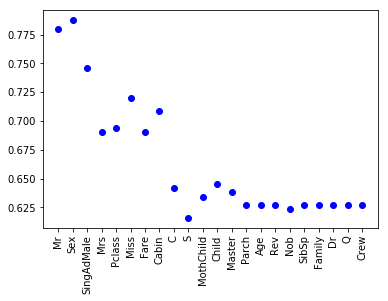

In [83]:
plt.plot(cols[1:],score,'bo')
plt.xticks(range(0,cols[1:].shape[0]), cols[1:], rotation='vertical')

In [81]:
for s in cols[1:]:
    #print(train[s])
    X_train, X_val, y_train, y_val = train_test_split(train[s].copy(), train['Survived'],
                                                      test_size=0.3, random_state=0)
    #print(y_train.shape,y_val.shape)
#    X_train.reshape(-1,1)
    print(X_train.values.reshape(1,-1).shape,y_train.values.shape)
#    print(type(X_train.values.reshape(1,-1),type(y_train.values))
    model = LogisticRegressionCV(cv = 3, fit_intercept= True,penalty='elasticnet',solver='saga')
    model.fit(pd.DataFrame(X_train.values.reshape(1,-1)),y_train)
    val_pred = model.predict(X_val)
#    score[n-2] = (val_pred==y_val).sum()/y_val.shape[0]
    print((val_pred==y_val).sum()/y_val.shape[0])

(1, 623) (623,)


ValueError: Found input variables with inconsistent numbers of samples: [1, 623]

In [ ]:
all_data.groupby(['Sex','Pclass'])['Age'].mean()

In [ ]:
all_data.loc(all_data['Age']<16)

In [ ]:
all_data

In [ ]:
skew(all_data['Fare'])

In [ ]:
np.isnan(all_data['Fare']).sum()

In [ ]:
all_data = groupbymedianreplace(all_data,['Sex','Pclass'])

In [ ]:
np.log1p(all_data['Age']).isna().sum()

In [ ]:
(np.log1p(all_data['Age'])).isna().sum()

In [ ]:
print(train[train['Pclass']==1]['Survived'].mean(),
train[train['Pclass']==2]['Survived'].mean(),
train[train['Pclass']==3]['Survived'].mean())

In [ ]:
print(train[train['Parch']==1]['Survived'].mean(),
train[train['Parch']==2]['Survived'].mean(),
train[train['Parch']==3]['Survived'].mean(),
train[train['Parch']==4]['Survived'].mean(),
train[train['Parch']==5]['Survived'].mean(),
train[train['Parch']==6]['Survived'].mean())

In [ ]:
pd.get_dummies(all_data['Embarked'])

In [ ]:
pd.concat([all_data,pd.get_dummies(all_data['Embarked'])],axis=1)

In [ ]:
all_data_copy

In [ ]:
all_data_copy.isna().sum()

In [ ]:
all_data_copy['Title'] = all_data_copy['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [ ]:
all_data_copy.isna().sum()

In [51]:
(all_data_copy['Title']=='Dr').sum()

8

In [199]:
train[all_data_copy['Title'][0:train.shape[0]]=='Dona']['Survived'].mean()

nan

In [248]:
all_data_copy['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr', 'Crew', 'Nob'],
      dtype=object)

In [247]:
all_data_copy.replace('Don','Mr',inplace=True)
all_data_copy.replace(['Mme','Dona'],'Mrs',inplace=True)
all_data_copy.replace(['Ms','Mlle'],'Miss',inplace=True)
all_data_copy.replace(['Major','Col','Capt'],'Crew',inplace=True)
all_data_copy.replace(['Lady','Sir','the Countess','Jonkheer'],'Nob',inplace=True)



In [124]:
all_data_copy[all_data_copy['Cabin'].isna()]['Cabin']=0

In [128]:
all_data_copy['Cabin'] = all_data_copy['Cabin'].fillna(0)

In [153]:
all_data_copy['Cabin'].isna()

0       True
1      False
2       True
3      False
4       True
5       True
6      False
7       True
8       True
9       True
10     False
11     False
12      True
13      True
14      True
15      True
16      True
17      True
18      True
19      True
20      True
21     False
22      True
23     False
24      True
25      True
26      True
27     False
28      True
29      True
       ...  
388     True
389     True
390    False
391    False
392     True
393     True
394     True
395    False
396     True
397    False
398     True
399     True
400    False
401     True
402     True
403     True
404    False
405    False
406     True
407    False
408     True
409     True
410     True
411    False
412     True
413     True
414    False
415     True
416     True
417     True
Name: Cabin, Length: 1309, dtype: bool

In [189]:
all_data_copy

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr
7,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [303]:
all_data.isna().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
Cabin     0
C         0
Q         0
S         0
Crew      0
Dr        0
Master    0
Miss      0
Mr        0
Mrs       0
Nob       0
Rev       0
Family    0
Child     0
dtype: int64

In [292]:
all_data_copy

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr
5,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,Q,Mr
6,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S,Mr
7,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S,Master
8,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S,Mrs
9,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C,Mrs


In [295]:
all_data_copy.groupby(['Title','Pclass'])['Age'].transform("mean")

0      28.318910
1      42.869565
2      17.360874
3      42.869565
4      28.318910
5      28.318910
6      41.439850
7       6.090000
8      32.326531
9      33.518519
10     17.360874
11     30.131148
12     28.318910
13     28.318910
14     17.360874
15     33.518519
16      6.090000
17     32.346715
18     32.326531
19     32.326531
20     32.346715
21     32.346715
22     17.360874
23     41.439850
24     17.360874
25     32.326531
26     28.318910
27     41.439850
28     17.360874
29     28.318910
         ...    
388    28.318910
389     6.090000
390    41.439850
391    42.869565
392     6.090000
393    32.346715
394    28.318910
395    42.869565
396    28.318910
397    42.869565
398    28.318910
399    28.318910
400    30.131148
401    32.346715
402    30.131148
403    41.439850
404    41.439850
405    32.346715
406    32.346715
407    41.439850
408    17.360874
409    17.360874
410    17.360874
411    42.869565
412    17.360874
413    28.318910
414    42.869565
415    28.3189

In [6]:
np.heaviside(-all_data_copy['Parch'],1)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      0.0
8      0.0
9      1.0
10     0.0
11     1.0
12     1.0
13     0.0
14     1.0
15     1.0
16     0.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     0.0
25     0.0
26     1.0
27     0.0
28     1.0
29     1.0
      ... 
388    1.0
389    0.0
390    1.0
391    0.0
392    0.0
393    1.0
394    0.0
395    1.0
396    1.0
397    0.0
398    1.0
399    1.0
400    1.0
401    1.0
402    0.0
403    1.0
404    1.0
405    1.0
406    1.0
407    0.0
408    1.0
409    0.0
410    1.0
411    1.0
412    1.0
413    1.0
414    1.0
415    1.0
416    1.0
417    0.0
Name: Parch, Length: 1309, dtype: float64